In [21]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
pandas.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pandas.set_option('display.width', 0)           # Désactive le wrap automatique
pandas.set_option('display.expand_frame_repr', False)  # Garde tout sur une ligne si possible
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize 
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import mfg_stats

In [34]:
import io_config

config = io_config.load_config('shipping_config.yaml')

save_fig = io_config.activate_save_fig(config)

# Get Regression Data

In [25]:
import pickle

save_coef_and_distances_in = config.outputs.regression.coef_and_distances
with open(save_coef_and_distances_in, "rb") as f:
    regressions_df = pickle.load(f)
regressions_df.sample(7)

,distKM_num,country_from,country_to,const,"(China, B)","(India, B)","(Japan, B)","(South Korea, B)","(Vietnam, B)",residuals,"(China, dest)","(India, dest)","(Japan, dest)","(South Korea, dest)","(Vietnam, dest)"
15,13862.202625,SAFR,China,5154.987243,-0.002837,-0.004148,0.008932,0.006196,-0.000821,9316.336840,True,False,False,False,False
22,18823.104100,US,Japan,9589.197406,-0.001949,-0.002444,-0.012714,-0.011777,0.000751,11357.268896,False,False,True,False,False
6,4537.691200,Indonesia,India,333976.393532,-0.040650,-0.044671,0.840579,0.264416,-0.039073,274908.946068,False,True,False,False,False
24,18196.787700,US,Vietnam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True
11,13014.139900,Russia,India,5616.864825,-0.002563,0.013028,0.053509,0.034794,0.044718,79115.035541,False,True,False,False,False
3,8279.180417,Australia,South Korea,-1538.823684,0.003377,-0.000402,0.055583,0.031076,0.031843,60525.191299,False,False,False,True,False
17,14866.335875,SAFR,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False


# Prepare data

# Structure for minimization

In [26]:
chelp = mfg_stats.create_cost_helper(regressions_df, renorm=10_000)
chelp.Aij_df

country_to,China,India,Japan,South Korea,Vietnam
country_from,,,,,
Australia,-2.133103,19.530567,3.023977,-0.153882,-3.807516
Indonesia,27.336921,33.397639,2.405610,4.227028,-2.089479
Russia,1.967640,0.561686,0.578747,3.378747,0.718503
SAFR,0.515499,9.340081,NaN,NaN,-5.401493
US,0.650972,4.566165,0.958920,NaN,NaN


# Derive costs and (relative) values from $A_{i,j}$ (main formula)

$$\min_{c, \{r_j\}, \{v_i\}} \sum_{i \ne j} \left\| A_{ij} \cdot \left( r_j + c \cdot T_{ij} \right) - \left( v_j - v_i \right) \right\|^2$$


# Initialize

In [27]:
x0_2 = np.array(
      [ 1.0,                       # c <-- transportation
        0.9, 1.8, 4.5, 2.2, 7.5,   # r <-- congestion
        1.0, 1.1, 1.2, 2.0, 1.3,   # v
        0.6, 1.0, 0.7, 0.8, 0.9])  #   <-- (relative) value
x0_ref = np.sqrt(x0_2)

x0_ref

array([1.        , 0.9486833 , 1.34164079, 2.12132034, 1.4832397 ,
       2.73861279, 1.        , 1.04880885, 1.09544512, 1.41421356,
       1.14017543, 0.77459667, 1.        , 0.83666003, 0.89442719,
       0.9486833 ])

In [28]:
x = x0_ref
c  = chelp.c(x)
r  = chelp.r(x)
vj = chelp.vj(x)
vi = chelp.vi(x)

In [29]:
np.sqrt(np.mean((chelp.Aij * (r + c * chelp.Tij) - (vj - vi))**2))

24.49891221483334

## Cost function

In [30]:
my_total_costs = lambda x: mfg_stats.total_cost(
    x, chelp=chelp)

my_total_costs(x0_ref)

24.49891221483334

In [31]:
print(f"A_ij ~ {regressions_df['const'].abs().mean()/chelp.renorm:,.0f}")
print(f"T_ij ~ {regressions_df['distKM_num'].abs().mean()/chelp.renorm:,.0f}")


A_ij ~ 6
T_ij ~ 1


### Memoize results

In [42]:
from tqdm.notebook import tqdm
from numpy.random import uniform as np_unif


rand_radius = 0.2 # 20% of randomization

temp_minimize = config.outputs.temp_minimize
results = io_config.memoize('read', temp_minimize + '_results.pkl', [])
x0_lst  = io_config.memoize('read',temp_minimize + '_x0_lst.pkl', [])


./data_out/memoize_min_results.pkl exists
./data_out/memoize_min_x0_lst.pkl exists


## Loop on optimize

In [52]:
# Optimisation
for i in tqdm(range(40)):
    # Tu peux modifier cette initialisation pour plus de variété
    x0 = x0_ref * (1-rand_radius/2 + np_unif(0, rand_radius))

    result = minimize(my_total_costs, x0, method='L-BFGS-B')
    
    if result.success:
        # Stocker le résultat dans le dictionnaire avec result.fun comme clé
        results.append(result)
        x0_lst.append(mfg_stats.extract_results(x0, result, chelp))

  0%|          | 0/40 [00:00<?, ?it/s]

In [54]:
io_config.memoize('w', temp_minimize + '_results.pkl', results)
io_config.memoize('w', temp_minimize + '_x0_lst.pkl', x0_lst)

<Axes: ylabel='Frequency'>

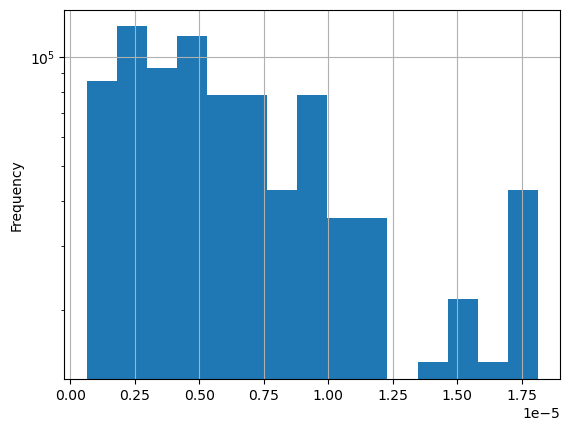

In [55]:
res_df = pandas.DataFrame(x0_lst)

res_df.loss.plot(kind='hist', bins=15, logy=True, density=True, grid=True)

## Extract best results

In [56]:
ind_min = res_df.loss.argmin()
best_x  = res_df.loc[ind_min,:]

best_loss = best_x['loss']
print(f"min loss = {best_loss}\n")

best_c  = best_x['c']
best_r  = best_x['r']
best_vj = best_x['vj']
best_vi = best_x['vi']

results[ind_min]

min loss = 6.364493629842878e-07



  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.364493629842878e-07
        x: [-1.108e-04 -3.541e-04 ...  8.975e-01  8.975e-01]
      nit: 115
      jac: [-7.972e-04 -2.394e-03 ...  4.005e-02 -1.072e-01]
     nfev: 2703
     njev: 159
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>

In [57]:
print("c ={c}\nr ={r}\nvj={vj}\nvi={vi}".format(**dict(
    c =best_c,
    r =best_r,
    vj=best_vj,
    vi=best_vi,
)))  

c =0.922877532331261
r =[0.83058978 1.66117956 4.1529489  2.03033057 6.92158149]
vj=[0.92287753 1.01516529 1.10745304 1.84575506 1.19974079]
vi=[0.55372652 0.92287753 0.64601427 0.73830203 0.83058978]


In [62]:
r_ser  = pandas.Series(best_r, index=chelp.c_to).rename('r_congestion')
vj_ser = pandas.Series(best_vj, index=chelp.c_to).rename('v_j')
vi_ser = pandas.Series(best_vi, index=chelp.c_from).rename('v_i')

## Results

In [139]:
print(f"c={best_c:.2f} transportation costs")

params_df = pandas.concat([r_ser, vj_ser, vi_ser], axis=1)
params_df

c=0.92 transportation costs


,r_congestion,v_j,v_i
China,0.830590,0.922878,NaN
India,1.661180,1.015165,NaN
Japan,4.152949,1.107453,NaN
South Korea,2.030331,1.845755,NaN
Vietnam,6.921581,1.199741,NaN
Australia,NaN,NaN,0.553727
Indonesia,NaN,NaN,0.922878
Russia,NaN,NaN,0.646014
SAFR,NaN,NaN,0.738302
US,NaN,NaN,0.830590


# Study

## Compare imports/exports to (relative) values

In [224]:
save_concatenated_and_truncated_ts_in = config.outputs.timeseries.save_concatenated_and_truncated_ts_in

import pickle

with open(save_concatenated_and_truncated_ts_in, "rb") as f:
    print(f"reading from <{save_concatenated_and_truncated_ts_in}>...")
    daily_exports_imports_df = pickle.load(f)


reading from <./data_out/all_from_to.pkl>...


In [225]:
shift = config.config.best_avg_params.shift
roll   = config.config.best_avg_params.roll
date_from = f'{config.config.best_avg_params.year_start}-06-01'
date_to   = f'{config.config.best_avg_params.year_end}-02-01'

config.config.best_avg_params._asdict()

{'shift': 60, 'roll': 20, 'year_start': 2018, 'year_end': 2021}

In [226]:
stat_container = mfg_stats.MFGStatContainer(daily_exports_imports_df)

dataset = stat_container.prepare_dataset(shift=-shift, roll=roll, drop_others='Others')

In [229]:
avg_from_to_df = dataset.from_to[date_from:date_to].mean().unstack() / 10_000
avg_from_to_df

country_to,China,India,Japan,Others,South Korea,Vietnam
country_from,,,,,,
Australia,4.901039,18.560524,2.764338,15.082214,1.454753,6.472545
Indonesia,26.820489,37.379283,2.136101,27.072619,2.953307,7.677369
Others,7.232145,11.385413,2.197241,NaN,3.687967,2.256847
Russia,4.151870,3.388281,1.516566,11.489401,4.232507,1.317900
SAFR,0.180440,11.533761,NaN,7.724420,NaN,2.296681
US,0.364721,5.317867,0.428904,13.247389,NaN,NaN


In [244]:
params_df['v_all'] = params_df['v_i'].fillna(0) + params_df['v_j'].fillna(0)
params_df['country_from'] = avg_from_to_df.sum(axis=1)
params_df['country_to']   = avg_from_to_df.sum(axis=0)

params_df

,r_congestion,v_j,v_i,v_all,country_from,country_to
China,0.830590,0.922878,NaN,0.922878,NaN,43.650703
India,1.661180,1.015165,NaN,1.015165,NaN,87.565129
Japan,4.152949,1.107453,NaN,1.107453,NaN,9.043151
South Korea,2.030331,1.845755,NaN,1.845755,NaN,12.328534
Vietnam,6.921581,1.199741,NaN,1.199741,NaN,20.021342
Australia,NaN,NaN,0.553727,0.553727,49.235413,NaN
Indonesia,NaN,NaN,0.922878,0.922878,104.039169,NaN
Russia,NaN,NaN,0.646014,0.646014,26.096525,NaN
SAFR,NaN,NaN,0.738302,0.738302,21.735302,NaN
US,NaN,NaN,0.830590,0.830590,19.358880,NaN


In [258]:
vj_df = pandas.concat(
    [params_df['v_j'].dropna().rename(ind) for ind in params_df['v_i'].dropna().index],
    axis=1
).T
vi_df = pandas.concat(
    [params_df['v_i'].dropna().rename(ind) for ind in params_df['v_j'].dropna().index],
    axis=1
)

In [273]:
delta_v_df = vj_df - vi_df
delta_v_df.round(2)

,China,India,Japan,South Korea,Vietnam
Australia,0.37,0.46,0.55,1.29,0.65
Indonesia,0.00,0.09,0.18,0.92,0.28
Russia,0.28,0.37,0.46,1.20,0.55
SAFR,0.18,0.28,0.37,1.11,0.46
US,0.09,0.18,0.28,1.02,0.37


In [274]:
avg_from_to_df.drop(index=['Others'], columns=['Others']).round(2)

country_to,China,India,Japan,South Korea,Vietnam
country_from,,,,,
Australia,4.90,18.56,2.76,1.45,6.47
Indonesia,26.82,37.38,2.14,2.95,7.68
Russia,4.15,3.39,1.52,4.23,1.32
SAFR,0.18,11.53,NaN,NaN,2.30
US,0.36,5.32,0.43,NaN,NaN


#### Comment

For the model: 
- China is a large importer and exporter...
- India has a lower congestion cost (explaining why there is more exports to India than the difference in relative value suggest)
- Indonesia is a large producer (the model does not have different sources), and is relatively closer to China and India than from the other countries

**Coal production (million tonnes)**
<pre>    
Country	2023
-----
China	    4,362.1	
India	      968.8	
Indonesia     781.3	
United States 524.0	
Russia	      479.9	
</pre>

In [270]:
def renorm_dataframe(df):
    return (df - df.stack().mean()) / df.stack().std()

renorm_dataframe(delta_v_df).round(2)

,China,India,Japan,South Korea,Vietnam
Australia,-0.31,-0.05,0.21,2.26,0.46
Indonesia,-1.34,-1.08,-0.82,1.23,-0.56
Russia,-0.56,-0.31,-0.05,2.00,0.21
SAFR,-0.82,-0.56,-0.31,1.75,-0.05
US,-1.08,-0.82,-0.56,1.49,-0.31


In [271]:
renorm_dataframe(avg_from_to_df.drop(index=['Others'], columns=['Others'])).round(2)

country_to,China,India,Japan,South Korea,Vietnam
country_from,,,,,
Australia,-0.21,1.22,-0.44,-0.58,-0.05
Indonesia,2.09,3.20,-0.51,-0.42,0.08
Russia,-0.29,-0.37,-0.57,-0.28,-0.59
SAFR,-0.71,0.48,NaN,NaN,-0.49
US,-0.69,-0.17,-0.68,NaN,NaN


## Using geopandas

In [76]:
!pip install geopandas | grep -v already

In [77]:
!pip install cartopy | grep -v already

In [72]:
!pip install geodatasets | grep -v already

In [73]:
import geopandas

In [74]:
import matplotlib.pyplot as plt
import geopandas
from cartopy import crs as ccrs
from geodatasets import get_path

path = get_path("naturalearth.land")
df = geopandas.read_file(path)

## Convert port Lat,Lon to geopandas

In [86]:
input_positions_file  = config.inputs.ports.input_positions_file
ports_list_df = pandas.read_csv(input_positions_file).rename(
    columns={'Pays': 'Country'}
)
ports_list_df.sample(3)

,Port,Latitude,Longitude,Country
79,Tianjin,38.9708,117.7339,China
0,Tanjung Priok,-6.1040,106.8865,Indonesia
46,Oakland,37.7950,-122.2790,US


In [231]:
countries_list_df = ports_list_df.groupby('Country')[['Latitude', 'Longitude']].mean().reset_index()

params_of_countries_df = pandas.merge(
                            params_df, countries_list_df,
                            left_index=True, right_on='Country')

#params_of_countries_df['v_all'] = (
#    params_of_countries_df['v_i'].fillna(0) +
#    params_of_countries_df['v_j'].fillna(0)
#)

nbe_colours = len(ports_list_df.Country.unique())
cm = plt.get_cmap('tab20')
colours = [cm(1.*i/nbe_colours) for i in range(nbe_colours)]
params_of_countries_df['colour'] = colours

params_of_countries_df.sample(3)

,r_congestion,v_j,v_i,v_all,Country,Latitude,Longitude,colour
6,NaN,NaN,0.738302,0.738302,SAFR,-32.09045,24.962913,"(0.7372549019607844, 0.7411764705882353, 0.133..."
8,NaN,NaN,0.830590,0.830590,US,35.07991,-96.792760,"(0.09019607843137255, 0.7450980392156863, 0.81..."
9,6.921581,1.199741,NaN,1.199741,Vietnam,13.61475,107.432500,"(0.5803921568627451, 0.403921568627451, 0.7411..."


In [232]:
ports_gdf = geopandas.GeoDataFrame(
    ports_list_df, geometry=geopandas.points_from_xy(ports_list_df.Longitude, ports_list_df.Latitude), crs="EPSG:4326"
)
ports_gdf.head()

,Port,Latitude,Longitude,Country,geometry
0,Tanjung Priok,-6.1040,106.8865,Indonesia,POINT (106.8865 -6.104)
1,Tanjung Perak,-7.1970,112.7331,Indonesia,POINT (112.7331 -7.197)
2,Belawan,3.7769,98.6859,Indonesia,POINT (98.6859 3.7769)
3,Teluk Bayur,-0.9735,100.3657,Indonesia,POINT (100.3657 -0.9735)
4,Cirebon,-6.7058,108.5703,Indonesia,POINT (108.5703 -6.7058)


In [233]:
countries_gdf = geopandas.GeoDataFrame(
    params_of_countries_df, geometry=geopandas.points_from_xy(countries_list_df.Longitude, countries_list_df.Latitude), crs="EPSG:4326"
)
countries_gdf.head()

,r_congestion,v_j,v_i,v_all,Country,Latitude,Longitude,colour,geometry
1,0.830590,0.922878,NaN,0.922878,China,32.086220,119.02573,"(0.12156862745098039, 0.4666666666666667, 0.70...",POINT (138.09314 -28.958)
2,1.661180,1.015165,NaN,1.015165,India,17.934840,78.26629,"(1.0, 0.4980392156862745, 0.054901960784313725...",POINT (119.02573 32.08622)
4,4.152949,1.107453,NaN,1.107453,Japan,34.592400,135.93479,"(0.17254901960784313, 0.6274509803921569, 0.17...",POINT (78.26629 17.93484)
7,2.030331,1.845755,NaN,1.845755,South Korea,35.422583,127.82045,"(0.8392156862745098, 0.15294117647058825, 0.15...",POINT (105.95173 -2.45909)
9,6.921581,1.199741,NaN,1.199741,Vietnam,13.614750,107.43250,"(0.5803921568627451, 0.403921568627451, 0.7411...",POINT (135.93479 34.5924)


### Plots

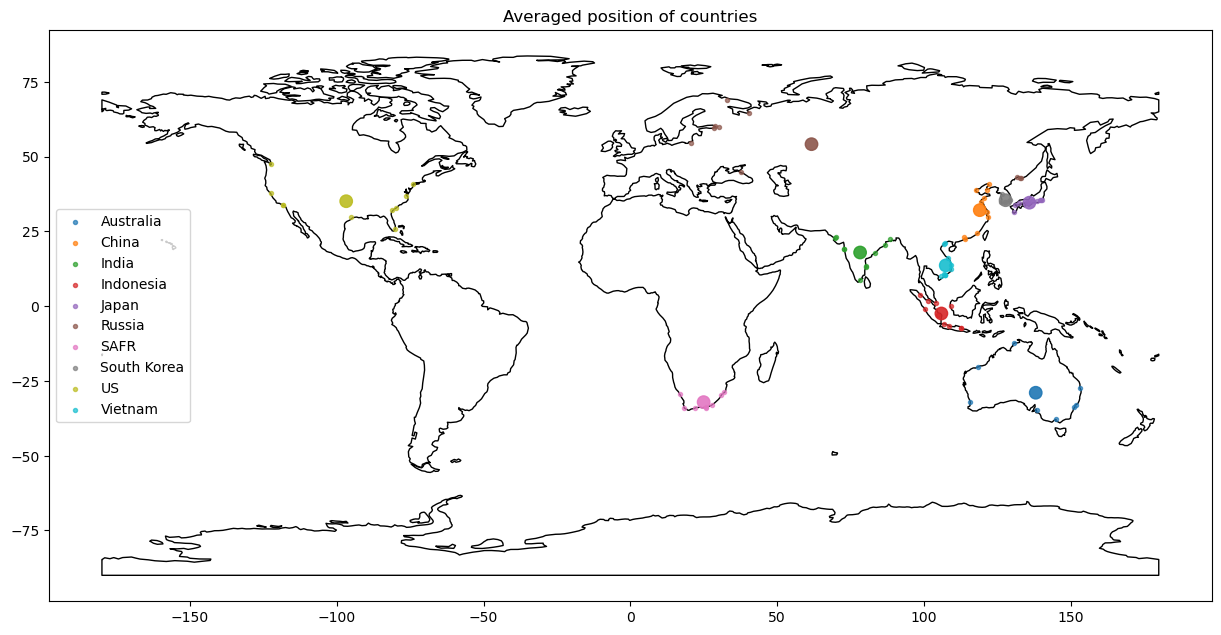

In [234]:
world = geopandas.read_file(get_path("naturalearth.land"))

ax = world.plot(color="white", edgecolor="black", figsize=(15,7.5))

# colormap
ax.set_prop_cycle(color=params_of_countries_df['colour'])
# We can now plot our ``GeoDataFrame``

for country, gdf in ports_gdf.groupby('Country'):
    gdf.plot(ax=ax, marker='.', markersize=34, alpha=0.7,
             label=country)
countries_gdf[['Country', 'Latitude', 'Longitude', 'geometry']].plot(
    ax=ax, marker='o', markersize=80, alpha=0.9, color=params_of_countries_df['colour'], label=None)

#plt.grid(True)
plt.title("Averaged position of countries")
plt.legend(loc='center left')


In [235]:
world = geopandas.read_file(get_path("naturalearth.land"))

def geoplot_param(
    world, params_of_countries_df, 
    param_name='r_congestion', title="Congestion parameter",
    r_mult = 220_000, c_marker='o', c_size=24):
    
    ax = world.plot(color="white", edgecolor="black", figsize=(15,7.5))
    
    # colormap
    ax.set_prop_cycle(color=params_of_countries_df['colour'])
    # We can now plot our ``GeoDataFrame``
    
    for country, gdf in ports_gdf.groupby('Country'):
        gdf.plot(ax=ax, marker=c_marker, markersize=c_size, alpha=0.7,
                 label=country)
    
    # create circles
    countries_with_circles = countries_gdf.dropna(subset=param_name).copy()
    
    # Convert to a projected CRS for accurate distance calculations
    countries_projected = countries_with_circles.to_crs('EPSG:3857')  # Web Mercator
    
    # Create circle polygons using buffer
    
    circle_polygons = []
    for i, radius in enumerate(countries_projected[param_name]):
        circle = countries_projected.iloc[i:i+1].buffer(radius * r_mult)
        circle_polygons.append(circle.iloc[0])
    
    # Create new GeoDataFrame with circle polygons
    circles_gdf = geopandas.GeoDataFrame(
        countries_with_circles[['Country', 'colour']],  # Your original data
        geometry=circle_polygons,
        crs='EPSG:3857'
    )
    
    # Convert back to geographic coordinates for plotting
    circles_gdf = circles_gdf.to_crs('EPSG:4326')
    
    circles_gdf.plot(ax=ax,
                     color=circles_gdf.colour,
                     alpha=0.6,
                     edgecolor='black',
                     linewidth=0.8)
    
    plt.title(title)
    plt.legend(loc='center left')

    return ax


image ./images/world_congestion.pdf exists, use force=True to replace


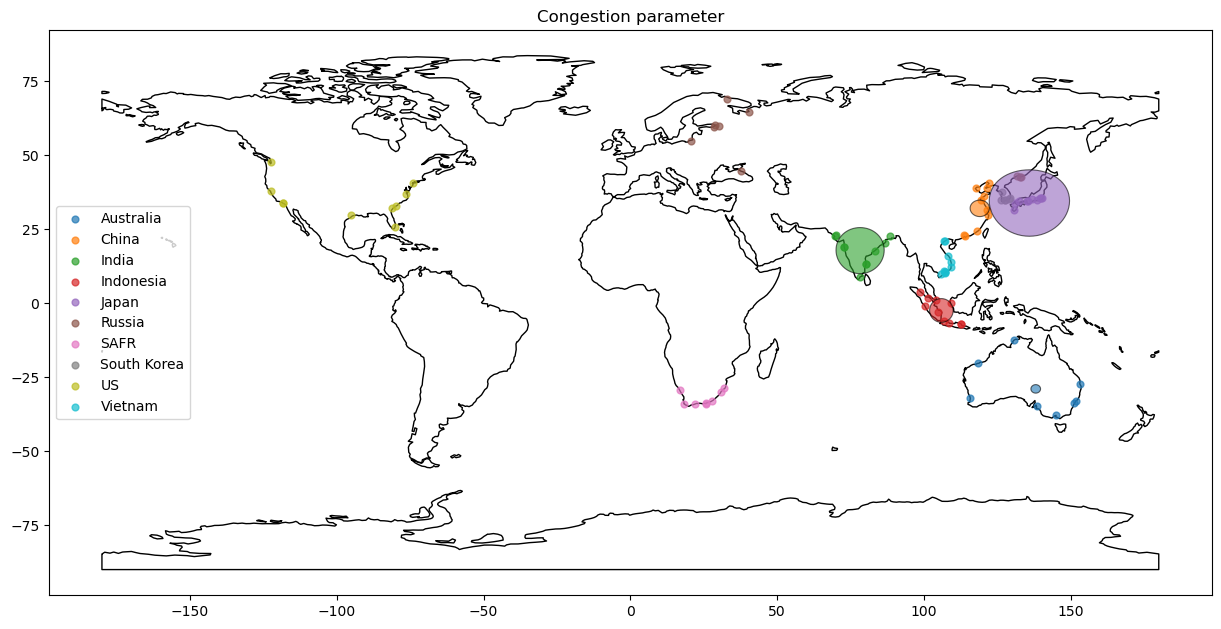

In [236]:
geoplot_param(
    world, params_of_countries_df, 
    param_name='r_congestion', title="Congestion parameter",
    r_mult = 220_000)
save_fig('world_congestion')

image ./images/world_relative_values.pdf exists, use force=True to replace


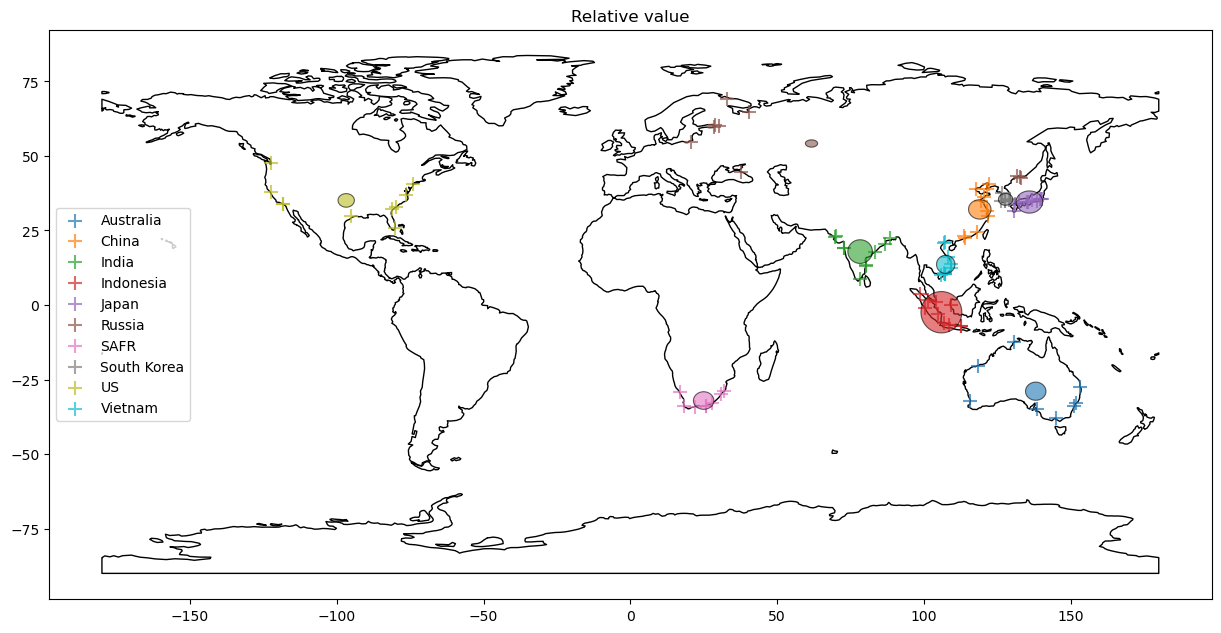

In [237]:
geoplot_param(
    world, params_of_countries_df, 
    param_name='v_all', title="Relative value",
    r_mult = 420_000, c_marker='+', c_size=88)
save_fig('world_relative_values')